In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# To allow interactive plot.
from ipywidgets import *
from IPython.display import display
from datetime import datetime, timedelta
import requests
import json
from time import sleep
import string

#import wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import pipeline, machine learning models, metrics and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix,roc_auc_score,precision_score
from sklearn.metrics.scorer import make_scorer
from imblearn.pipeline import make_pipeline,Pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

#import feature extraction from nltk and sklearn
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import hstack,csr_matrix

from spacy.lemmatizer import Lemmatizer
import en_core_web_sm
from spacy import vocab


Using TensorFlow backend.


## Data Problem Statement

   **FAKE NEWS is a problem:**
   In the era of Social Media where news spread is just one click away, fake news spreads quicker and further than ever. The inability to trust news is undoubtedly a problem for people and nations as a whole. 
    
In this project we first use a labeled dataset to attempt fake news detection.

**Type A dataset: MisInfoText, Buzzfeed Dataset (2019)**
    Fatemeh Torabi Asr and Maite Taboada (2019) MisInfoText. A collection of news articles, with false and true labels. Dataset.
    
The news for this source was first taken from various Facebook groups by three Buzzfeed reporters, and were labeled with 4 classes:
    
        -Mostly True
        -Mixture of True and False
        -Mostly False
        -No Factual Content
    
The authors of this dataset then followed the URLs in the first dataset, and scraped the full text of each news article from its original source. The resulting dataset includes a total of 1380 news articles on a focused topic (US election and candidates). Veracity labels come in a four-way classification scheme including 1090 mostly true, 170 mixture of true and false, 64 mostly false and 56 articles containing no factual content.

| Type | Count |
| ------------- |:-------------:|
| **Mostly True** | 1090| 
| **Mixture of True and False** |  170 | 
| **Mostly False** |  64| 
| **No Factual Content** |  56 | 
    


## Data Cleaning 

### Snopes Dataset

In [6]:

snopes=pd.read_csv('Datasets/snopes_checked_v03.csv')
snopes.head(3)

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2,Jerry-label,Jill-label,Fatemeh-label,notes,original order,Agreement
0,mixture,https://www.snopes.com/fact-check/elizabeth-wa...,Did Elizabeth Warren Lie About Her Native Amer...,Politics Politicians,30-Oct-14,Elizabeth Warren lives in a multi-million-doll...,https://www.bostonglobe.com/metro/2012/01/13/e...,3,True,No Error,"Elizabeth Warren, the Harvard Law School profe...","Elizabeth Warrens salary topped $700,000 over ...",1/13/12,Noah Bierman,context,context,context,NaN,1,NaN
1,mixture,https://www.snopes.com/fact-check/the-company-...,"Animal Testing Resumes for Avon, Mary Kay, and...",Critter Country Media Matters,31-Mar-15,"Cosmetic companies Avon, Mary Kay and Este Lau...",http://www.thedogfiles.com/2012/02/27/animal-t...,3,True,No Error,As of right now I dont know what kinds of anim...,"Animal Testing Resumes For Avon, Mary Kay, And...",2/27/12,Kenn Bell,right,right,right,NaN,2,NaN
2,mixture,https://www.snopes.com/fact-check/hillary-clin...,Did Hillary Clinton Tell FBIs Mueller to Deliv...,Politics Conspiracy Theories,21-Jun-17,Then-Secretary of State Clinton ordered then-F...,https://www.intellihub.com/hillary-clinton-req...,4,True,No Error,\r\r\r\r\r\r Former Secretary of State Hillar...,Hillary Clinton requested FBI Dir. Mueller del...,6/19/17,Shepard Ambellas,right,right,right,NaN,3,NaN


### Check for null data
    None. Yay!

In [7]:
snopes.isnull().sum()

fact_rating_phase1                 0
snopes_url_phase1                  0
article_title_phase1               0
article_category_phase1            0
article_date_phase1                0
article_claim_phase1               0
article_origin_url_phase1          0
index_paragraph_phase1             0
page_is_first_citation_phase1      0
error_phase2                       0
original_article_text_phase2       0
article_title_phase2               3
publish_date_phase2              130
author_phase2                    189
Jerry-label                        0
Jill-label                         0
Fatemeh-label                      0
notes                            274
original order                     0
Agreement                        251
dtype: int64

In [8]:
## We only need the text and overall rating
snopes=snopes[['fact_rating_phase1','original_article_text_phase2']]

In [9]:
snopes.dtypes

fact_rating_phase1              object
original_article_text_phase2    object
dtype: object

In [10]:
snopes.columns=['rating','text']

### Removal of non main-text occurrences

These adverts are a result of poor scraping, but are hard to discover by hand. We search for the top n-grams to root out these occurrences.

In [11]:
X=snopes['text']

In [21]:
cvec=CountVectorizer(max_df=1.0,
                     min_df=3,
                     ngram_range=(5,5),
                     token_pattern=r'\S+',
                     lowercase=True)

In [22]:
X_T=cvec.fit_transform(X)

In [32]:
cvec.get_feature_names()

['at the center of the',
 'at the time of the',
 'department of health and human',
 'department of housing and urban',
 'for disease control and prevention',
 'her use of a private',
 'in the second half of',
 'is one of the most',
 'of housing and urban development',
 'see also [ edit ]',
 'senate majority leader mitch mcconnell',
 'the department of homeland security,',
 'the department of housing and',
 'the food and drug administration',
 'this is the first time',
 'use of a private email']

**There doesnt seem to be any problematic text, and this corpus was better scraped**

## Data Visualization

### Class balance (Ratings)

**Check Class Balance**  

In [8]:
snopes['rating'].value_counts()

mixture         72
mostly true     71
TRUE            65
mostly false    53
FALSE           51
Name: rating, dtype: int64

<BarContainer object of 5 artists>

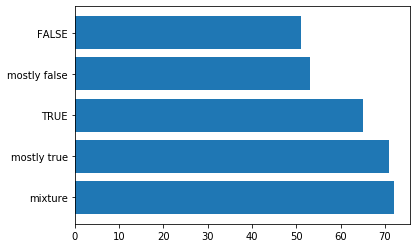

In [9]:
plt.barh(snopes['rating'].value_counts().index,snopes['rating'].value_counts().values)

    Classes seem to be quite balanced

### Word Count

In [10]:
textlen['textlen']=snopes['text'].apply(lambda x: len(x.split(' ')))

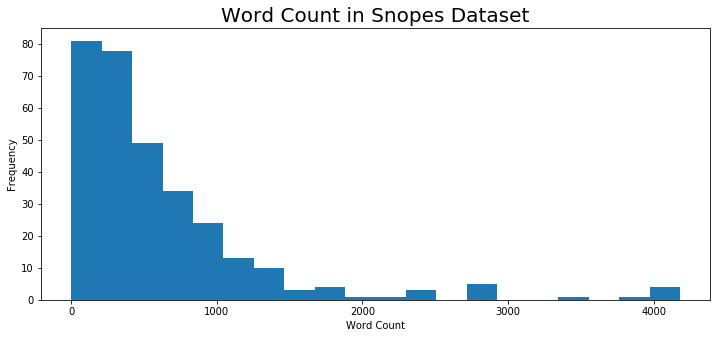

In [11]:
plt.figure(figsize=(12,5))
plt.hist(textlen['textlen'],bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count in Snopes Dataset',fontdict={'size':20})
plt.show()

### Word Cloud

In [12]:
mostlytrue=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(snopes[snopes['rating']=='mostly true']['text'].sum())
mixture=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(snopes[snopes['rating']=='mixture']['text'].sum())
mostlyfalse=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(snopes[snopes['rating']=='mostly false']['text'].sum())
nfc=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(snopes[snopes['rating']=='FALSE']['text'].sum())
true=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(snopes[snopes['rating']=='TRUE']['text'].sum())

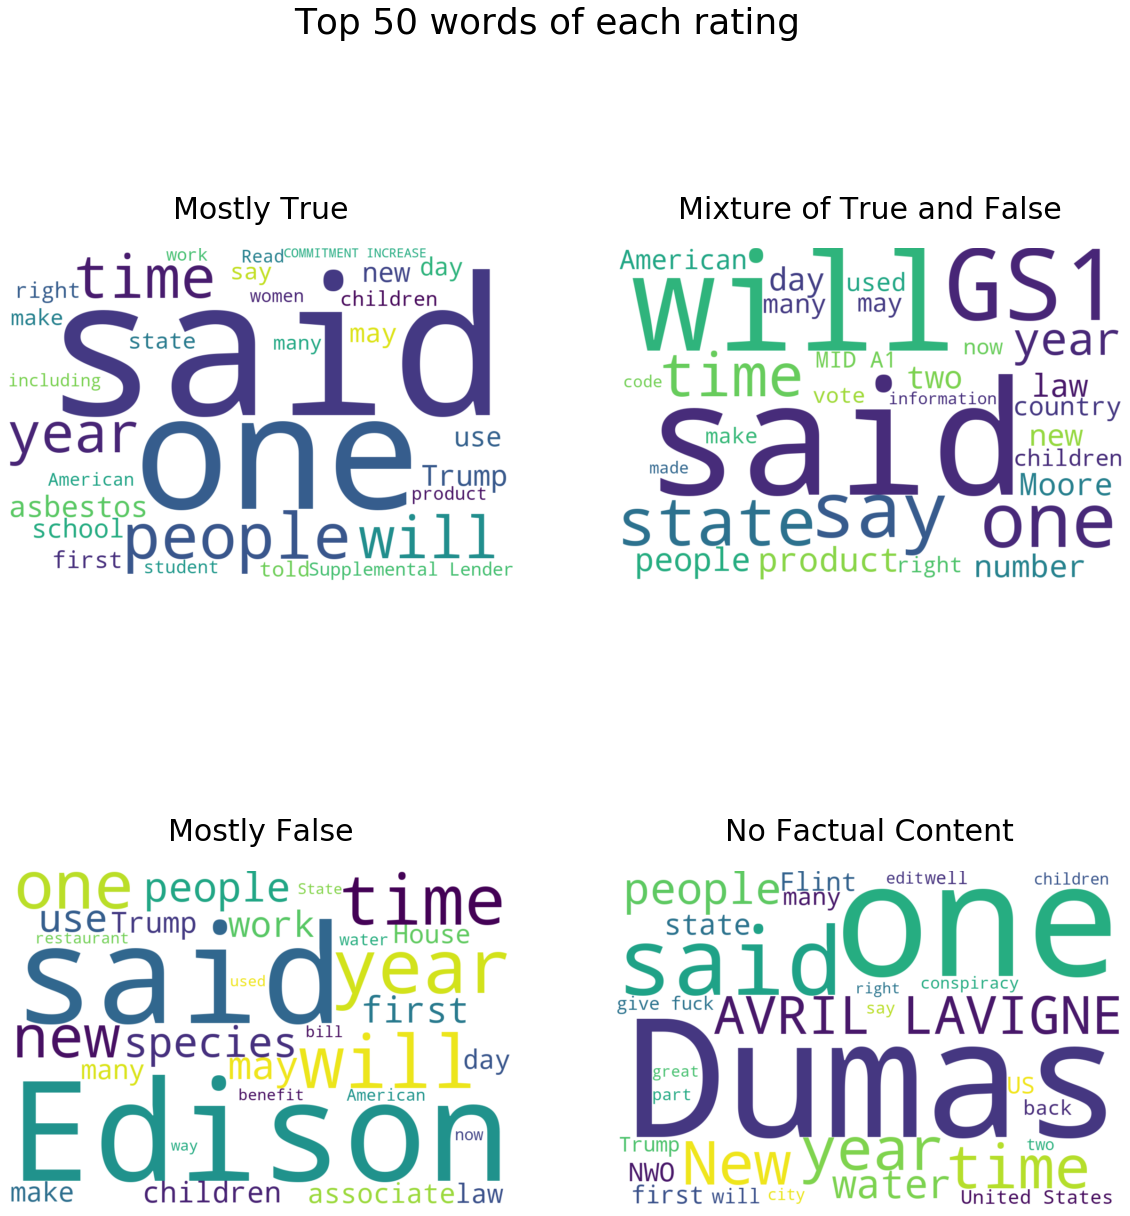

In [50]:
ncols=2
nrows=3
fig,ax=plt.subplots(ncols=ncols,nrows=2,figsize=(ncols*10,7*nrows))
ax=ax.ravel()
cloudlist=[mostlytrue,mixture,mostlyfalse,nfc,true]
cloudtitles=['Mostly True','Mixture of True and False','Mostly False','No Factual Content','True']
for n,axes in enumerate(ax):
    axes.axis("off")
    axes.imshow(cloudlist[n], interpolation='bilinear')
    axes.set_title(str(cloudtitles[n]),fontsize=30,pad=30)

fig.suptitle('Top 50 words of each rating',fontsize=36,)

plt.show()

## Preprocessing

    Because are only interested in detecting whether news contains false information, we turn this into a binary classification problem by classifying "Mostly true" as the negative class and all other ratings as the positive class

### Defining the target

In [14]:
snopes['rating'].isnull().sum()

0

In [15]:
snopes['target']=snopes['rating'].apply(lambda x: 0 if (x=='mostly true' or x=='TRUE') else 1)

In [16]:
snopes['target'].value_counts()

1    176
0    136
Name: target, dtype: int64

In [17]:
snopes['target'].shape

(312,)

### NLTK Lemmatization

In [36]:
nlp = en_core_web_sm.load()
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
exclude.add('\r')
lemma = WordNetLemmatizer()

def nltklemma(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized



[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
snopes['nltklemma']=snopes['text'].apply(lambda x:nltklemma(x))

### Spacy Lemmatization

In [36]:
nlp = en_core_web_sm.load()
#with full text
def spacy_lemma(doc):

    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    
    text=nlp(punc_free)
    newtext=[]
    for token in text:
        if not (token.is_stop):
            if not(token.is_punct):
                newtext.append(token.lemma_)

    return " ".join(token for token in newtext)
#With scrubbed pronouns
def spacy_lemma2(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    text=nlp(punc_free)
    newtext=[]
    for token in text:
        if not token.is_stop:
            if not(token.is_punct):
                if(token.pos_ == 'PROPN')or(token.pos=='NOUN'):
                    newtext.append(token.pos_)
                else:
                    newtext.append(token.lemma_)

    return " ".join(token for token in newtext)

In [38]:
#snopes['spacylemma']=snopes['text'].apply(lambda x: spacy_lemma(x))
snopes['spacylemma2']=snopes['text'].apply(lambda x: spacy_lemma2(x))

In [39]:
#snopes['spacylemma']=snopes['text'].apply(lambda x: spacy_lemma(x))
snopes['spacylemma']=snopes['text'].apply(lambda x: spacy_lemma(x))

In [ ]:
snopes

### Position of speech bag of words

In [34]:
def spacy_pos(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_stop:
            newtext.append(token)

    return " ".join(token.pos_ for token in newtext)


def spacy_pos2(doc):
    text=nlp(doc)
    newtext=[]
    for token in text:
        if not token.is_punct:
            newtext.append(token)

    return " ".join(token.pos_ for token in newtext)

In [37]:
snopes['spacy_pos']=snopes['text'].apply(lambda x: spacy_pos(x))
snopes['spacy_pos2']=snopes['text'].apply(lambda x: spacy_pos2(x))

### Save to Csv

In [39]:
snopes.isnull().sum()

rating         0
text           0
target         0
nltklemma      0
spacylemma2    0
spacylemma     0
spacy_pos      0
spacy_pos2     0
dtype: int64

In [38]:
snopes.head()

,rating,text,target,nltklemma,spacylemma2,spacylemma,spacy_pos,spacy_pos2
0,mixture,"Elizabeth Warren, the Harvard Law School profe...",1,elizabeth warren harvard law school professor ...,PROPN PROPN PROPN PROPN PROPN professor consum...,Elizabeth Warren Harvard Law School professor ...,PROPN PROPN PUNCT PROPN PROPN PROPN NOUN NOUN ...,PROPN PROPN DET PROPN PROPN PROPN NOUN CCONJ N...
1,mixture,As of right now I dont know what kinds of anim...,1,right dont know kind animal using kenn animal ...,right not know kind animal PROPN test cosmetic...,right not know kind animal KennAnimal test cos...,ADV PART VERB NOUN NOUN PUNCT SPACE PROPN SPAC...,SCONJ ADP ADV ADV PRON AUX PART VERB PRON NOUN...
2,mixture,\r\r\r\r\r\r Former Secretary of State Hillar...,1,former secretary state hillary clinton facilit...,PROPN PROPN PROPN PROPN facilitate transfer...,Secretary State Hillary Clinton facilitate ...,SPACE PROPN PROPN PROPN PROPN VERB NOUN ADV AD...,SPACE ADJ PROPN ADP PROPN PROPN PROPN VERB DET...
3,mixture,Crushing Lamps\r\rCrushing and breaking fluore...,1,crushing lamp crushing breaking fluorescent la...,crush PROPN break fluorescent lamp release PRO...,crush LampsCrushing break fluorescent lamp rel...,VERB NOUN SPACE VERB VERB NOUN NOUN VERB PROPN...,VERB NOUN SPACE VERB CCONJ VERB NOUN NOUN VERB...
4,mixture,"This was their response: ""Logistically, we cou...",1,response logistically could add flag without r...,response logistically add flag remove flag pol...,response logistically add flag remove flag pol...,NOUN PUNCT PUNCT ADV PUNCT VERB NOUN VERB NOUN...,DET AUX PRON NOUN ADV PRON AUX PART VERB DET N...


In [48]:
snopes.dropna(inplace=True)

In [40]:
snopes.to_csv('Cleaned CSV/snopesclean.csv',index=False)

In [41]:
snopes=pd.read_csv('Cleaned CSV/snopesclean.csv')